#### Library Imports

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import datetime
from copy import deepcopy


#### Exploring the Data

In [4]:
df = pd.read_csv("TSLA.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
...,...,...,...,...,...,...,...
3255,2023-06-05,217.800003,221.289993,214.520004,217.610001,217.610001,151143100
3256,2023-06-06,216.139999,221.910004,212.529999,221.309998,221.309998,146911600
3257,2023-06-07,228.000000,230.830002,223.199997,224.570007,224.570007,185710800
3258,2023-06-08,224.220001,235.229996,223.009995,234.860001,234.860001,164489700


In [6]:
df = df[['Date', 'Close']]
df

,Date,Close
0,2010-06-29,1.592667
1,2010-06-30,1.588667
2,2010-07-01,1.464000
3,2010-07-02,1.280000
4,2010-07-06,1.074000
...,...,...
3255,2023-06-05,217.610001
3256,2023-06-06,221.309998
3257,2023-06-07,224.570007
3258,2023-06-08,234.860001


In [8]:
df['Date']

0       2010-06-29
1       2010-06-30
2       2010-07-01
3       2010-07-02
4       2010-07-06
           ...    
3255    2023-06-05
3256    2023-06-06
3257    2023-06-07
3258    2023-06-08
3259    2023-06-09
Name: Date, Length: 3260, dtype: object

In [9]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('2010-06-06')
datetime_object

datetime.datetime(2010, 6, 6, 0, 0)

In [10]:
df

,Date,Close
0,2010-06-29,1.592667
1,2010-06-30,1.588667
2,2010-07-01,1.464000
3,2010-07-02,1.280000
4,2010-07-06,1.074000
...,...,...
3255,2023-06-05,217.610001
3256,2023-06-06,221.309998
3257,2023-06-07,224.570007
3258,2023-06-08,234.860001


import altair as alt
from google.colab import autoviz
df_4247157860136387207 = autoviz.get_registered_df('df_4247157860136387207')

def histogram(df, colname, maxbins=20, width=100, height=50):
  return (alt.Chart(df).mark_bar()
          .encode(
              x=alt.X(colname, bin=alt.Bin(maxbins=maxbins)),
              y=alt.Y('count()', axis=alt.Axis(title='count')),
          )
          .properties(width=width, height=height))  #  Pixels.

chart = histogram(df_4247157860136387207, *['Close'], **{})
chart

import altair as alt
from google.colab import autoviz
df_5847279143348749395 = autoviz.get_registered_df('df_5847279143348749395')

def value_plot(df, y, sort_ascending=False, width=100, height=50):
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  return (alt.Chart(df.reset_index()).mark_line()
          .encode(x=alt.X('index', title=''), y=alt.X(y, title='value'))
          .properties(width=width, height=height, title=y))

chart = value_plot(df_5847279143348749395, *['Close'], **{})
chart

In [11]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

<ipython-input-11-f6fc52bb0fa5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0      2010-06-29
1      2010-06-30
2      2010-07-01
3      2010-07-02
4      2010-07-06
          ...    
3255   2023-06-05
3256   2023-06-06
3257   2023-06-07
3258   2023-06-08
3259   2023-06-09
Name: Date, Length: 3260, dtype: datetime64[ns]

In [12]:
df.index = df.pop('Date')
df

,Close
Date,
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-06,1.074000
...,...
2023-06-05,217.610001
2023-06-06,221.309998
2023-06-07,224.570007


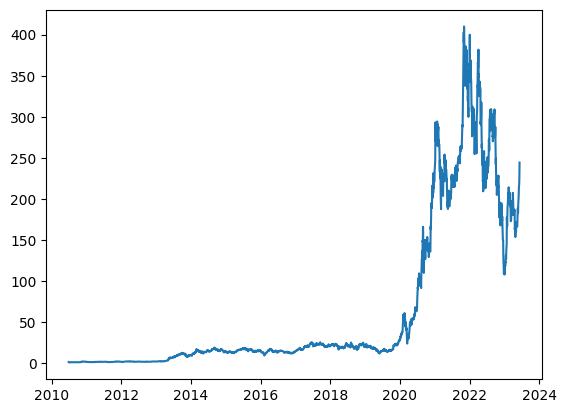

In [15]:
plt.plot(df.index, df['Close'])

#### Feature Engineering

In [16]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

windowed_df = df_to_windowed_df(df, 
                                '2021-06-11', 
                                '2023-06-09', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-06-11,201.196671,199.593338,203.373337,203.296661
1,2021-06-14,199.593338,203.373337,203.296661,205.896667
2,2021-06-15,203.373337,203.296661,205.896667,199.786667
3,2021-06-16,203.296661,205.896667,199.786667,201.623337
4,2021-06-17,205.896667,199.786667,201.623337,205.533340
...,...,...,...,...,...
498,2023-06-05,203.929993,207.520004,213.970001,217.610001
499,2023-06-06,207.520004,213.970001,217.610001,221.309998
500,2023-06-07,213.970001,217.610001,221.309998,224.570007
501,2023-06-08,217.610001,221.309998,224.570007,234.860001


import altair as alt
from google.colab import autoviz
df_1453676593894158235 = autoviz.get_registered_df('df_1453676593894158235')

def histogram(df, colname, maxbins=20, width=100, height=50):
  return (alt.Chart(df).mark_bar()
          .encode(
              x=alt.X(colname, bin=alt.Bin(maxbins=maxbins)),
              y=alt.Y('count()', axis=alt.Axis(title='count')),
          )
          .properties(width=width, height=height))  #  Pixels.

chart = histogram(df_1453676593894158235, *['index'], **{})
chart

import altair as alt
from google.colab import autoviz
df_4726503295492559519 = autoviz.get_registered_df('df_4726503295492559519')

def histogram(df, colname, maxbins=20, width=100, height=50):
  return (alt.Chart(df).mark_bar()
          .encode(
              x=alt.X(colname, bin=alt.Bin(maxbins=maxbins)),
              y=alt.Y('count()', axis=alt.Axis(title='count')),
          )
          .properties(width=width, height=height))  #  Pixels.

chart = histogram(df_4726503295492559519, *['Target-3'], **{})
chart

import altair as alt
from google.colab import autoviz
df_2310181987025372196 = autoviz.get_registered_df('df_2310181987025372196')

def histogram(df, colname, maxbins=20, width=100, height=50):
  return (alt.Chart(df).mark_bar()
          .encode(
              x=alt.X(colname, bin=alt.Bin(maxbins=maxbins)),
              y=alt.Y('count()', axis=alt.Axis(title='count')),
          )
          .properties(width=width, height=height))  #  Pixels.

chart = histogram(df_2310181987025372196, *['Target-2'], **{})
chart

import altair as alt
from google.colab import autoviz
df_2496183620387045622 = autoviz.get_registered_df('df_2496183620387045622')

def histogram(df, colname, maxbins=20, width=100, height=50):
  return (alt.Chart(df).mark_bar()
          .encode(
              x=alt.X(colname, bin=alt.Bin(maxbins=maxbins)),
              y=alt.Y('count()', axis=alt.Axis(title='count')),
          )
          .properties(width=width, height=height))  #  Pixels.

chart = histogram(df_2496183620387045622, *['Target-1'], **{})
chart

import altair as alt
from google.colab import autoviz
df_2108640092879061136 = autoviz.get_registered_df('df_2108640092879061136')

def value_plot(df, y, sort_ascending=False, width=100, height=50):
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  return (alt.Chart(df.reset_index()).mark_line()
          .encode(x=alt.X('index', title=''), y=alt.X(y, title='value'))
          .properties(width=width, height=height, title=y))

chart = value_plot(df_2108640092879061136, *['index'], **{})
chart

import altair as alt
from google.colab import autoviz
df_3997224560188296780 = autoviz.get_registered_df('df_3997224560188296780')

def value_plot(df, y, sort_ascending=False, width=100, height=50):
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  return (alt.Chart(df.reset_index()).mark_line()
          .encode(x=alt.X('index', title=''), y=alt.X(y, title='value'))
          .properties(width=width, height=height, title=y))

chart = value_plot(df_3997224560188296780, *['Target-3'], **{})
chart

import altair as alt
from google.colab import autoviz
df_4707599676329935324 = autoviz.get_registered_df('df_4707599676329935324')

def value_plot(df, y, sort_ascending=False, width=100, height=50):
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  return (alt.Chart(df.reset_index()).mark_line()
          .encode(x=alt.X('index', title=''), y=alt.X(y, title='value'))
          .properties(width=width, height=height, title=y))

chart = value_plot(df_4707599676329935324, *['Target-2'], **{})
chart

import altair as alt
from google.colab import autoviz
df_5942475715019433971 = autoviz.get_registered_df('df_5942475715019433971')

def value_plot(df, y, sort_ascending=False, width=100, height=50):
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  return (alt.Chart(df.reset_index()).mark_line()
          .encode(x=alt.X('index', title=''), y=alt.X(y, title='value'))
          .properties(width=width, height=height, title=y))

chart = value_plot(df_5942475715019433971, *['Target-1'], **{})
chart

import altair as alt
from google.colab import autoviz
df_5761820194505023576 = autoviz.get_registered_df('df_5761820194505023576')

def linked_scatter_plots(
    df, colname_pairs, color='steelblue', deselected_color='lightgray',
    opacity=0.8, deselected_opacity=0.4, width=150, height=150):
  interval = alt.selection_interval()
  scatter = (alt.Chart(df).mark_circle()
             .encode(
                 color=alt.condition(
                     interval, alt.value(color), alt.value(deselected_color)),
                 opacity=alt.condition(
                     interval, alt.value(opacity),
                     alt.value(deselected_opacity)))
             .properties(
                 selection=interval, width=width, height=height))
  return alt.hconcat(*[scatter.encode(x=x, y=y) for x, y in colname_pairs])

chart = linked_scatter_plots(df_5761820194505023576, *[[['index', 'Target-3'], ['Target-3', 'Target-2'], ['Target-2', 'Target-1'], ['Target-1', 'Target']]], **{})
chart

#### Data Transformation for LSTM

In [17]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((503,), (503, 3, 1), (503,))

#### Splitting the Data

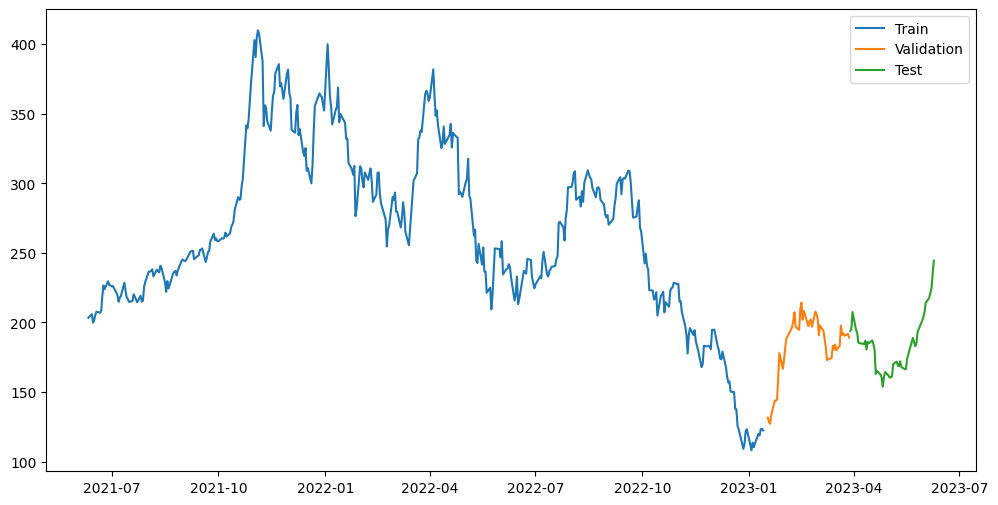

In [30]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.figure(figsize=(12,6))
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

#### LSTM

In [19]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
13/13 [==============================] - 3s 35ms/step - loss: 74118.2031 - mean_absolute_error: 264.9654 - val_loss: 33866.5312 - val_mean_absolute_error: 182.6773
Epoch 2/100
13/13 [==============================] - 0s 5ms/step - loss: 73698.4297 - mean_absolute_error: 264.1752 - val_loss: 33555.8789 - val_mean_absolute_error: 181.8244
Epoch 3/100
13/13 [==============================] - 0s 5ms/step - loss: 73170.1094 - mean_absolute_error: 263.1663 - val_loss: 33052.0703 - val_mean_absolute_error: 180.4338
Epoch 4/100
13/13 [==============================] - 0s 5ms/step - loss: 72227.2969 - mean_absolute_error: 261.3689 - val_loss: 32194.2578 - val_mean_absolute_error: 178.0396
Epoch 5/100
13/13 [==============================] - 0s 4ms/step - loss: 70670.4453 - mean_absolute_error: 258.3690 - val_loss: 30686.0645 - val_mean_absolute_error: 173.7357
Epoch 6/100
13/13 [==============================] - 0s 4ms/step - loss: 67642.5312 - mean_absolute_error: 252.3459 - val_lo

#### Comparing the Training Predictions

13/13 [==============================] - 0s 2ms/step


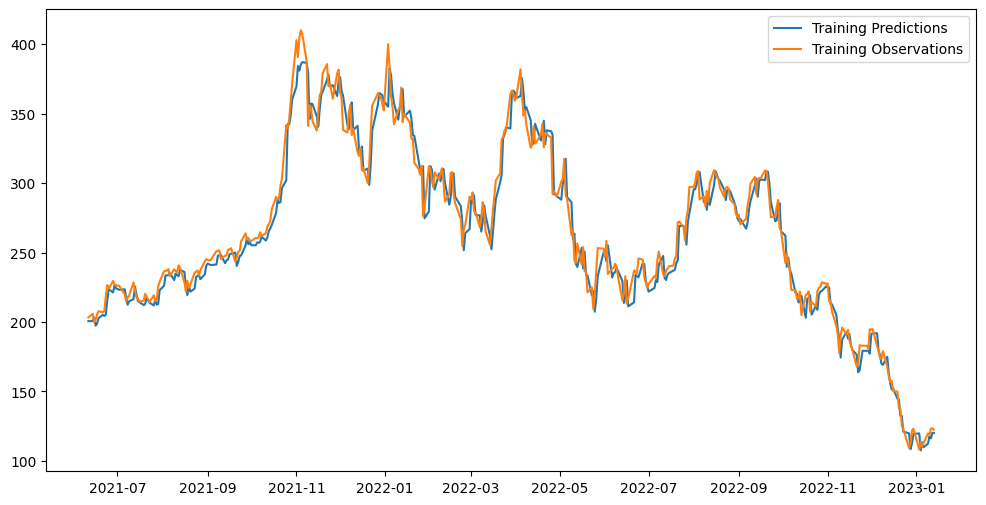

In [29]:
train_predictions = model.predict(X_train).flatten()
plt.figure(figsize=(12,6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

#### Comparing the Validation Predictions

2/2 [==============================] - 0s 7ms/step


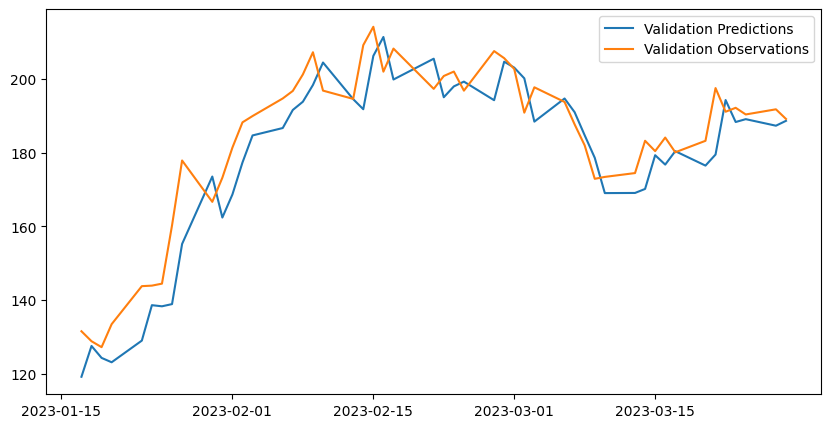

In [28]:
val_predictions = model.predict(X_val).flatten()
plt.figure(figsize=(10,5))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

#### Comparing the Testing Predictions

2/2 [==============================] - 0s 10ms/step


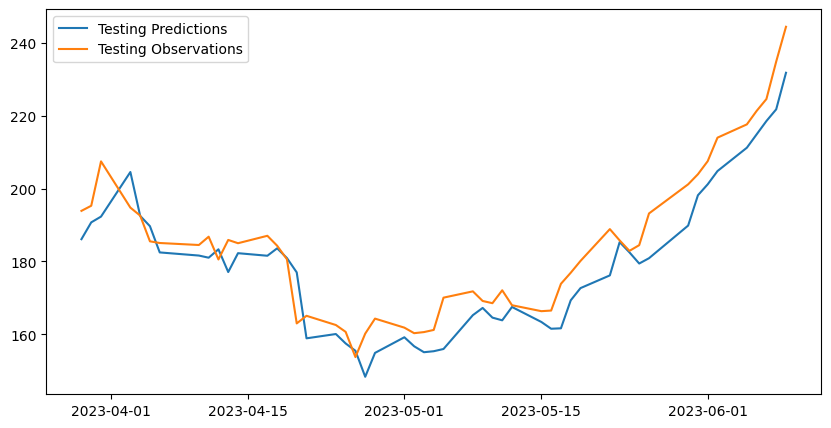

In [27]:
plt.figure(figsize=(10,5))
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

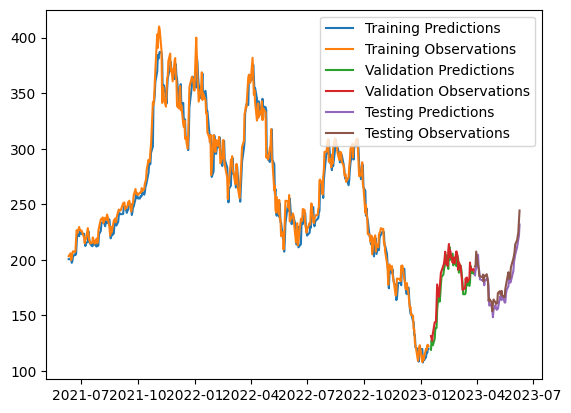

In [23]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

#### Performing Recursive Predictions

In [24]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 16ms/step


#### Visualizing the Predictions

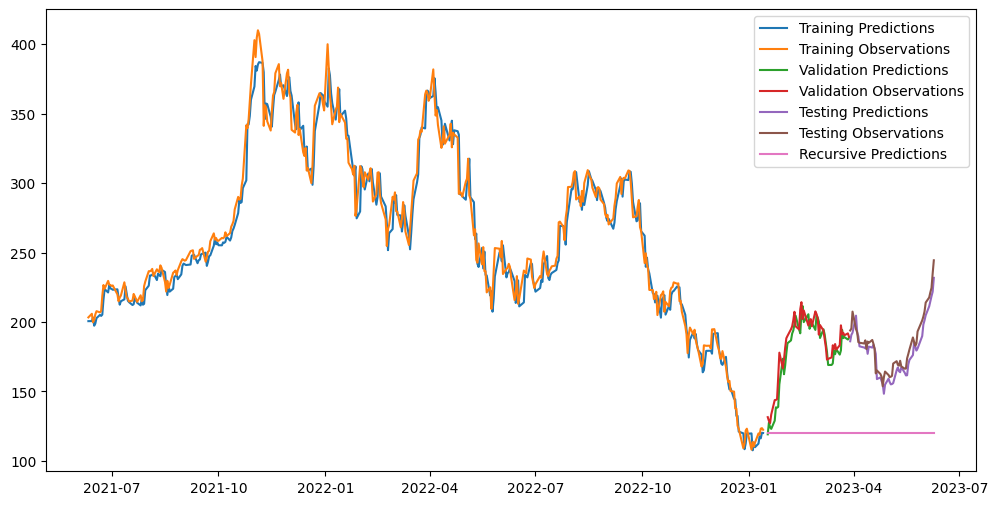

In [26]:
plt.figure(figsize=(12,6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])